# Install required libraries

In [66]:
#!pip install tweetnlp

In [67]:
#!python -m spacy download en_core_web_lg

# Import required libraries

In [68]:
import pandas as pd
import spacy
import re
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,Embedding, Dropout, BatchNormalization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import tweetnlp

# Part One


## Data Preparation

The first part of this project is about starting off with the basics. We first load our data, making sure it's ready for use. Then, we take a quick look at it to understand what's there - checking out what kind of information we have, spotting any obvious patterns or odd things. This step helps us get ready for the more detailed work that comes next.

In [69]:
train_path = '/content/twitter_training.csv'
val_path = '/content/twitter_validation.csv'

In [70]:
df_train = pd.read_csv(train_path)
df_val = pd.read_csv(val_path)

In [71]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column                                                 Non-Null Count  Dtype 
---  ------                                                 --------------  ----- 
 0   2401                                                   74681 non-null  int64 
 1   Borderlands                                            74681 non-null  object
 2   Positive                                               74681 non-null  object
 3   im getting on borderlands and i will murder you all ,  73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [72]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 4 columns):
 #   Column                                                                                                                                                                                                                                              Non-Null Count  Dtype 
---  ------                                                                                                                                                                                                                                              --------------  ----- 
 0   3364                                                                                                                                                                                                                                                999 non-null    int64 
 1   Facebook                                                                   

Right now, the dataset doesn't have any column names. To make it easier to understand and work with, we're going to add names to each column. This will help us know what each part of the data is about and make analyzing the data simpler.

In [73]:
columns = ['textID','location', 'sentiment', 'text' ]

In [74]:
df_train.columns = columns
df_val.columns = columns

In [133]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73995 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     73995 non-null  int64 
 1   location   73995 non-null  object
 2   sentiment  73995 non-null  object
 3   text       73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.8+ MB


In [75]:
df_train.head()

,textID,location,sentiment,text
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [76]:
df_val.head()

,textID,location,sentiment,text
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


Moving forward, we will remove any entries from our dataset that contain null values in either the 'Text' or 'Sentiment' columns.

In [77]:
def remove_null_texts(df,col):
    """
    Remove rows where the 'text' column is null.
    """
    # Displaying the number of null values in the 'text' column
    null_texts_count = df[col].isnull().sum()
    print(f"Number of null values in the {col} column: {null_texts_count}")

    # Dropping rows where the 'text' column is null
    df_cleaned = df.dropna(subset=[col])

    # Displaying the number of rows removed
    print(f"Number of rows removed: {null_texts_count}")

    return df_cleaned

In [78]:
df_train = remove_null_texts(df_train,'text')
df_train = remove_null_texts(df_train,'sentiment')

Number of null values in the text column: 686
Number of rows removed: 686
Number of null values in the sentiment column: 0
Number of rows removed: 0


In [79]:
df_val = remove_null_texts(df_val,'text')
df_val = remove_null_texts(df_val,'sentiment')

Number of null values in the text column: 0
Number of rows removed: 0
Number of null values in the sentiment column: 0
Number of rows removed: 0


In [80]:
print('df_train Shape',df_train.shape)
print('df_val Shape',df_val.shape)

df_train Shape (73995, 4)
df_val Shape (999, 4)


Next, we are going to streamlin the dataset to concentrate on key information. Specifically, we will retain only the **text** and **sentiment** columns. These two columns are important for our analysis needs. The **text** column provides the actual content we want to examine, while the **sentiment** column offers valuable insights into the emotional tone of each text entry.

In [81]:
df_train_small = df_train[['text','sentiment']]
df_val_small = df_val[['text','sentiment']]

In [82]:
df_train_small.head()

,text,sentiment
0,I am coming to the borders and I will kill you...,Positive
1,im getting on borderlands and i will kill you ...,Positive
2,im coming on borderlands and i will murder you...,Positive
3,im getting on borderlands 2 and i will murder ...,Positive
4,im getting into borderlands and i can murder y...,Positive


In [83]:
df_val_small.head()

,text,sentiment
0,BBC News - Amazon boss Jeff Bezos rejects clai...,Neutral
1,@Microsoft Why do I pay for WORD when it funct...,Negative
2,"CSGO matchmaking is so full of closet hacking,...",Negative
3,Now the President is slapping Americans in the...,Neutral
4,Hi @EAHelp I’ve had Madeleine McCann in my cel...,Negative


We will merge these datasets for combined processing, and we will add an 'Index' column, which will facilitate separating them again at a later stage.

In [84]:
train_index = 'train'
validation_index = 'validation'
df = pd.concat([df_train_small.assign(ind=train_index),df_val_small.assign(ind=validation_index)])

In [85]:
df.shape

(74994, 3)

In [86]:
df.head()

,text,sentiment,ind
0,I am coming to the borders and I will kill you...,Positive,train
1,im getting on borderlands and i will kill you ...,Positive,train
2,im coming on borderlands and i will murder you...,Positive,train
3,im getting on borderlands 2 and i will murder ...,Positive,train
4,im getting into borderlands and i can murder y...,Positive,train


Now, let's analyze the data to gain deeper insights.

In [87]:
def countplot_sentiment_distribution(df,col):
    """
    Plot the distribution of sentiments in the dataframe.
    """
    # Setting the aesthetic style of the plots
    sns.set_style("whitegrid")

    # Creating the plot
    plt.figure(figsize=(7, 5))
    sns.countplot(data=df, x=col, palette='viridis')

    # Adding titles and labels
    plt.title(f"{col} Distribution", fontsize=15)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Displaying the plot
    plt.show()

In [88]:
def histplot_text_length_distribution(data):
    plt.figure(figsize=(8, 6))
    sns.histplot(data['text'].str.len(), bins=30, kde=False)
    plt.title('Text Length Distribution')
    plt.xlabel('Text Length')
    plt.ylabel('Frequency')
    plt.show()

In [89]:
def pie_sentiment_distribution1(data):
    sentiment_counts = data['sentiment'].value_counts()
    plt.figure(figsize=(6, 6))
    plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title('Sentiment Distribution')
    plt.show()

In [90]:
def plot_average_text_length_by_sentiment(data):
    data['text_length'] = data['text'].str.len()
    average_length_by_sentiment = data.groupby('sentiment')['text_length'].mean()
    plt.figure(figsize=(8, 6))
    average_length_by_sentiment.plot(kind='bar', color=['blue', 'green', 'red'])
    plt.title('Average Text Length by Sentiment')
    plt.xlabel('Sentiment')
    plt.ylabel('Average Text Length')
    plt.xticks(rotation=0)
    plt.show()

In [91]:
def boxplot_length_distribution(df):
    """
    Plot the distribution of tweet lengths by sentiment with enhanced Y-axis granularity.

    Parameters:
    df (pandas.DataFrame): DataFrame containing 'text' and 'sentiment' columns.
    """
    # Calculate tweet lengths
    df['text_length'] = df['text'].apply(len)

    # Initialize the matplotlib figure
    plt.figure(figsize=(10, 6))

    # Create a boxplot
    sns.boxplot(x='sentiment', y='text_length', data=df, showfliers=True, showmeans=True)

    plt.title('Distribution of Tweet Lengths by Sentiment')
    plt.xlabel('Sentiment')
    plt.ylabel('Length of text')

    # Enhancing Y-axis granularity
    max_length = df['text_length'].max()
    plt.yticks(range(0, max_length + 1, 25))  # Adjust the step (50 in this case) as needed

    # Show the plot
    plt.show()


In [92]:
def filter_and_convert_sentiments(df, sentiment_mapping):
    """
    Filters a DataFrame to keep only specified sentiments and converts those sentiment labels to numerical values.

    Parameters:
    - df: DataFrame containing the Twitter data with a 'Sentiment' column.
    - sentiment_mapping: Dictionary with sentiment text as keys and their numeric representation as values.

    Returns:
    - df: Processed DataFrame with sentiments converted to their corresponding numerical values.
    """

    # Create a copy of the DataFrame to avoid SettingWithCopyWarning
    df_filtered = df[df['sentiment'].isin(sentiment_mapping.keys())].copy()

    # Convert sentiment labels to their corresponding numerical values using the sentiment_mapping
    df_filtered['sentiment'] = df_filtered['sentiment'].map(sentiment_mapping)

    return df_filtered

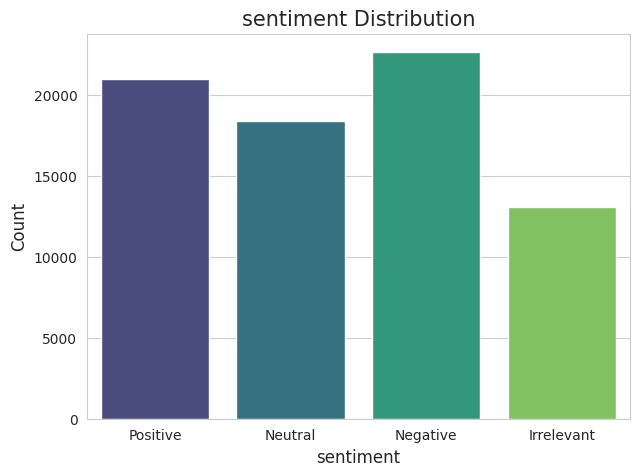

In [93]:
countplot_sentiment_distribution(df,'sentiment')

The sentiment distribution analysis reveals that the 'Sentiment' field has the following classes:

- Negative
- Positive
- Neutral
- Irrelevant

We will remove Irrlevant data. Also, to optimize the performance of our predictive model, we will transform the categorical sentiment labels into numerical values.

In [94]:
sentiment_mapping = {
    'Positive': 0,
    'Negative': 1,
    'Neutral':2
}
df['sentiment_text']=df['sentiment']
df = filter_and_convert_sentiments(df, sentiment_mapping)

In [95]:
df.head()

,text,sentiment,ind,sentiment_text
0,I am coming to the borders and I will kill you...,0,train,Positive
1,im getting on borderlands and i will kill you ...,0,train,Positive
2,im coming on borderlands and i will murder you...,0,train,Positive
3,im getting on borderlands 2 and i will murder ...,0,train,Positive
4,im getting into borderlands and i can murder y...,0,train,Positive


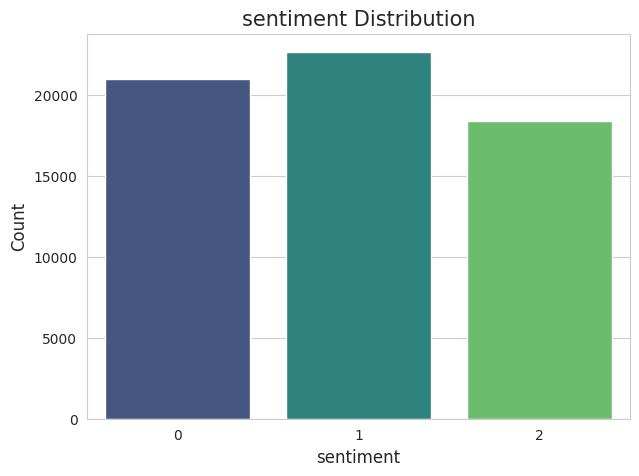

In [96]:
countplot_sentiment_distribution(df,'sentiment')

The classes are balanced

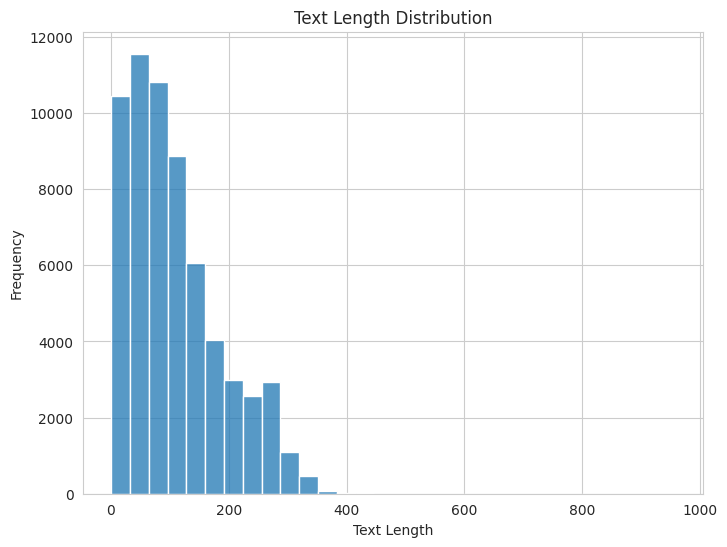

In [97]:
histplot_text_length_distribution(df)

The graph appears to have a right-skewed distribution. This suggests that most of the texts are on the shorter side, with fewer texts having a longer length.

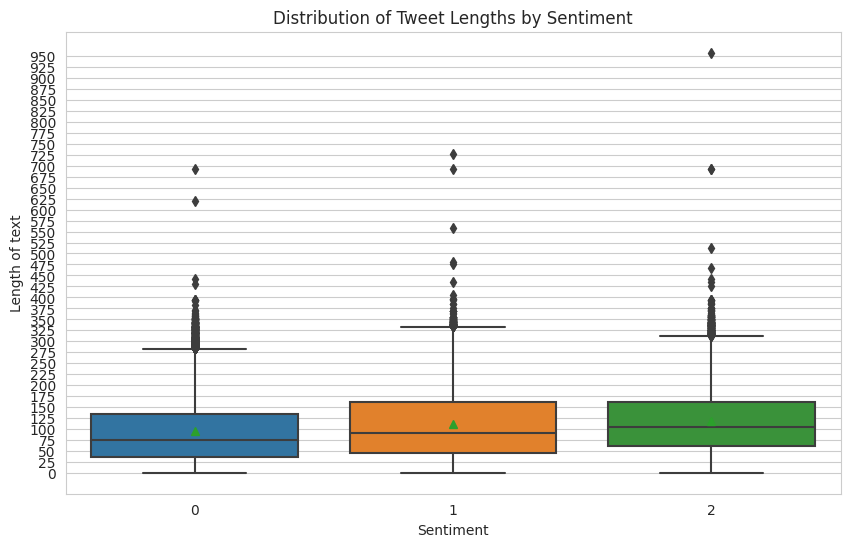

In [98]:
df.text=df.text.astype(str)
boxplot_length_distribution(df)

The graph indicates the presence of numerous outliers characterized by longer text lengths. It appears that these outliers begin at a text length of around 260. To further investigate, we will examine how many entries in the database have a text length exceeding 260 characters.

In [99]:
def count_long_texts(df, threshold=260):
    """
    Count the number of texts longer than a specified threshold and calculate their percentage.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the 'text' column.
    threshold (int): Length threshold for considering a text as 'long'.

    Returns:
    None: Prints the count and percentage of long texts.
    """
    # Count the number of texts longer than the threshold
    long_texts_count = df[df['text'].str.len() > threshold].shape[0]

    # Calculate the percentage of long texts
    total_texts = df.shape[0]
    long_texts_percentage = (long_texts_count / total_texts) * 100

    # Print the results
    print(f"Number of texts longer than {threshold} characters: {long_texts_count}")
    print(f"Percentage of texts longer than {threshold} characters: {long_texts_percentage:.2f}%")


In [100]:
 count_long_texts(df)

Number of texts longer than 260 characters: 4038
Percentage of texts longer than 260 characters: 6.52%


The texts exceeding 260 characters constitute 6.52% of our dataset. To enhance model performance, we've decided to exclude them. Retaining these longer texts previously resulted in extensive computation times and suboptimal performance.

In [101]:
# Remove texts longer than 260
df = df[df['text_length']<= 260]


In [102]:
count_long_texts(df)

Number of texts longer than 260 characters: 0
Percentage of texts longer than 260 characters: 0.00%


<ipython-input-91-f51664b8bba8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_length'] = df['text'].apply(len)


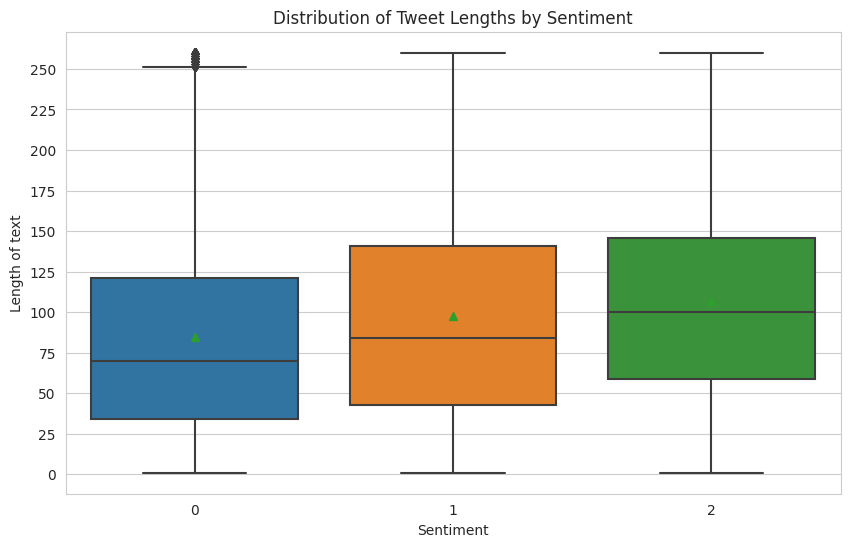

In [103]:
boxplot_length_distribution(df)

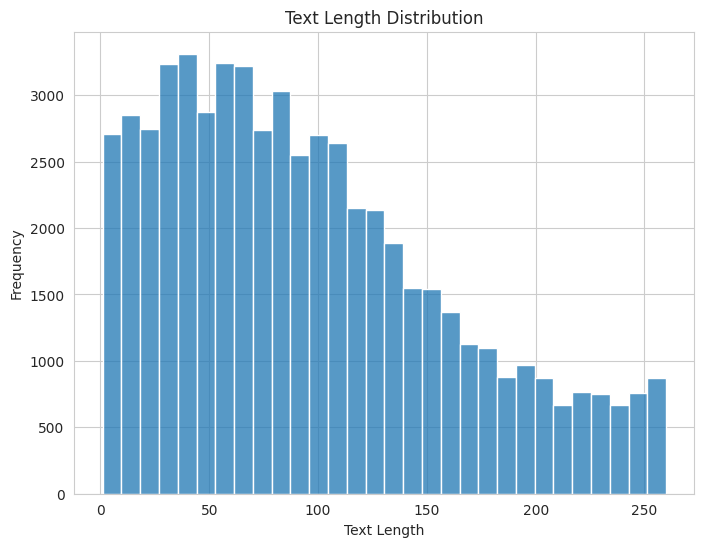

In [104]:
histplot_text_length_distribution(df)

We will remove outliers in an effort to create a more uniform dataset, potentially enhancing the model's predictive accuracy. While we recognize that outliers can often provide useful insights, our previous attempts to use all records did not yield satisfactory performance. We are now exploring different approaches to improve the results

In [105]:
def remove_outliers(df, column_name, iqr_multiplier=3):
    """
    Remove outliers from a dataframe based on the Interquartile Range (IQR) method.

    Parameters:
    df (pandas.DataFrame): The dataframe from which to remove outliers.
    column_name (str): The name of the column based on which outliers will be identified.
    iqr_multiplier (float): The multiplier for the IQR to define the bounds for outliers.

    Returns:
    pandas.DataFrame: A new dataframe with outliers removed.
    """
    # Calculate the IQR
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    # Define the bounds for outliers
    lower_bound = Q1 - iqr_multiplier * IQR
    upper_bound = Q3 + iqr_multiplier * IQR

    # Filter the dataframe to remove outliers
    filtered_df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    return filtered_df

In [106]:
df.shape

(57910, 5)

In [107]:
df = remove_outliers(df, 'text_length',iqr_multiplier=1)

In [108]:
df.shape

(55278, 5)

In [109]:
print("Number of rows removed:", 57910-55278)

Number of rows removed: 2632


We will check the dataset for any texts that are less than 2 characters long, and remove them. These short texts usually aren't helpful for our work.

In [110]:
df = df.sort_values(by='text_length')

In [111]:
df.head(10)

,text,sentiment,ind,sentiment_text,text_length
72365,,1,train,Negative,1
62242,a,1,train,Negative,1
43679,,1,train,Negative,1
8687,,1,train,Negative,1
34288,I,2,train,Neutral,1
43961,,1,train,Negative,1
68848,a,0,train,Positive,1
8873,,2,train,Neutral,1
62021,,2,train,Neutral,1
44212,A,0,train,Positive,1


In [112]:
# Remove texts less than 3
df = df[df['text_length'] > 2]

In [113]:
df.head(10)

,text,sentiment,ind,sentiment_text,text_length
32620,the,1,train,Negative,3
32644,can,2,train,Neutral,3
4522,and,1,train,Negative,3
24382,was,0,train,Positive,3
67042,You,0,train,Positive,3
2413,...,1,train,Negative,3
66368,wtf,1,train,Negative,3
26434,not,0,train,Positive,3
2986,...,2,train,Neutral,3
34336,out,0,train,Positive,3


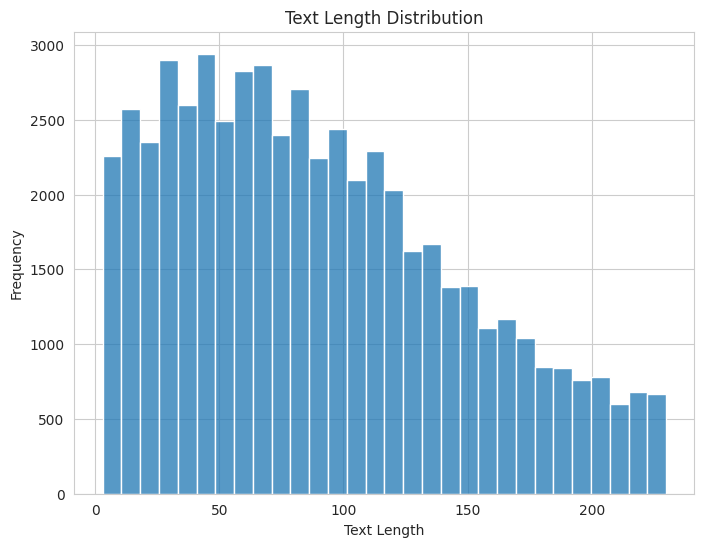

In [114]:
histplot_text_length_distribution(df)

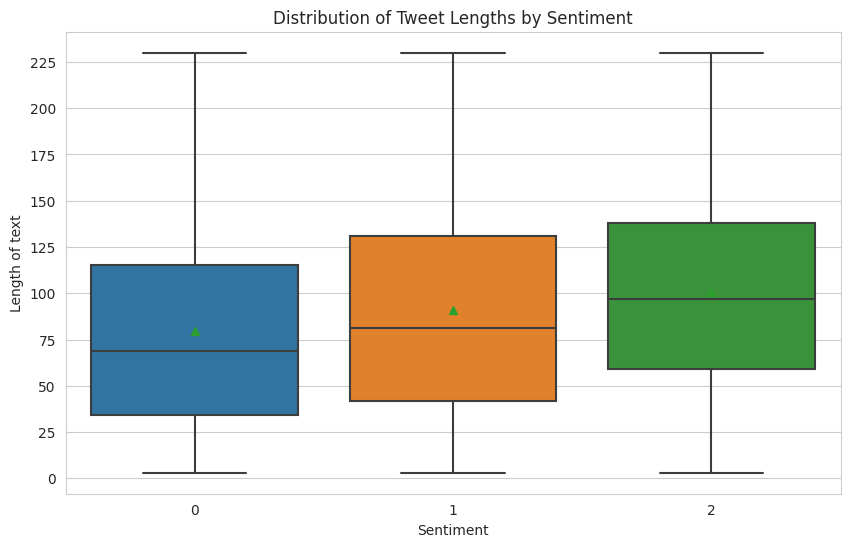

In [115]:
boxplot_length_distribution(df)

In [116]:
df.shape

(54558, 5)

In [117]:
def count_short_text_words(df, max_length=4):
    """
    Get all records with text length of max_length or less, count each word, and return the results.

    Parameters:
    df (pandas.DataFrame): The DataFrame with a 'text' column.
    max_length (int): The maximum length of text to consider.

    Returns:
    pandas.DataFrame: A DataFrame with word counts.
    """
    # Filter to get texts of length max_length or less
    short_texts = df[df['text'].str.len() <= max_length]

    # Split the texts into words and count the occurrences
    word_counts = short_texts['text'].str.split(expand=True).stack().value_counts()

    # Convert the Series to a DataFrame
    word_counts_df = word_counts.reset_index()
    word_counts_df.columns = ['Word', 'Count']

    # Print the word counts
    print(word_counts_df)

    return word_counts_df

In [118]:
result_df = count_short_text_words(df)

     Word  Count
0     the     61
1     you     55
2     Wow     50
3    that     25
4    Wow.     23
..    ...    ...
139  was.      1
140    Me      1
141  STOP      1
142  LS!!      1
143  Aha.      1

[144 rows x 2 columns]


The dataset still includes some short texts that are just one word. While words like 'WOW' and 'STOP' could be useful, others like 'the' and 'you' might not be as valuable. For the time being, We'll keep these texts and observe how they impact our analysis.

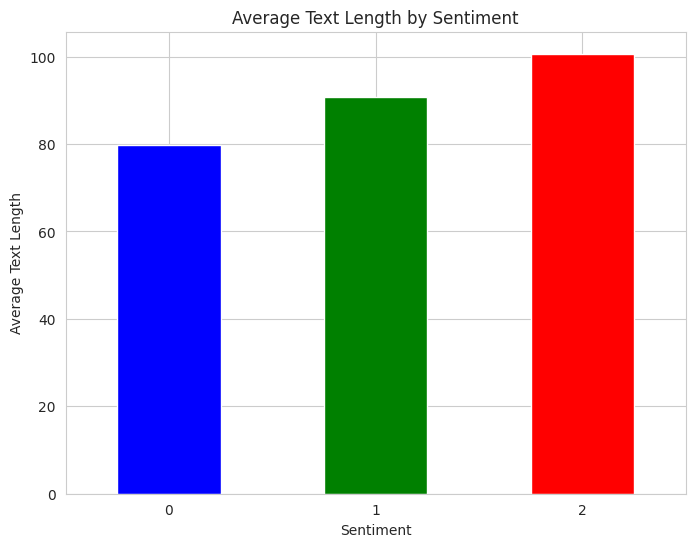

In [119]:
plot_average_text_length_by_sentiment(df)

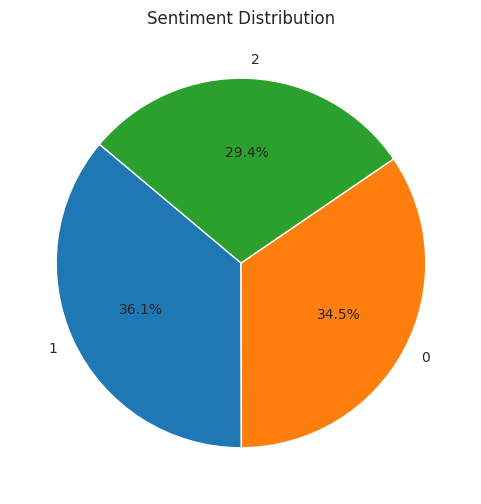

In [120]:
pie_sentiment_distribution1(df)

The classes are still balanced, removing the outliers did not affect them

In [121]:
df.tail(10)

,text,sentiment,ind,sentiment_text,text_length
47729,"Hug it out, let the strong survive, the weak p...",0,train,Positive,230
6914,If there is anyone out there who has found and...,2,train,Neutral,230
64873,Congrats to Joke! Finally consolidating that i...,0,train,Positive,230
45733,If you haven't used your cell phone for the la...,1,train,Negative,230
70657,"@ GhostRecon @ Ubisoft Your game is broken, so...",1,train,Negative,230
37159,"Perhaps I am not the first to see this, but Ma...",2,train,Neutral,230
24132,@ Irina _ Vukolova...... Last night we saw oth...,0,train,Positive,230
6274,@NyxJacob Thanks for entering Grand<unk>.. Rev...,2,train,Neutral,230
44756,"Tricia B., a recruiter at Verizon, are proud o...",2,train,Neutral,230
53295,org I just realised Red Dead Redemption turned...,0,train,Positive,230


## Data Preprocessing
We need to standardize and simplify the text data, which is crucial for effective natural language processing (NLP). The following steps need to be done:

- Tokenizing: Breaks down text into individual words or tokens, making it easier for the model to process and learn from the text data.

- Converting to Lowercase: Ensures consistency by treating words like "Hello" and "hello" as the same word, avoiding duplication in the model's v- ocabulary.

- Removing Stop Words: Eliminates common words (e.g., "the", "is", "in") that usually don't contribute to the sentiment of the text, allowing the model to focus on more meaningful words.

- Lemmatizing: Reduces words to their base or root form, which helps in consolidating different forms of the same word, so they are analyzed as a single item.

Together, these preprocessing steps clean and refine the text data, leading to better model performance by focusing on the most relevant features of the text.

In [61]:
nlp = spacy.load('en_core_web_lg')

In [130]:
# Lemmatizes words and removes stop words.
def lemmatize_and_remove_stopwords(text):
    return " ".join([token.lemma_ for token in nlp(text) if not token.is_stop])

# Converts text to lowercase.
def to_lowercase(text):
    return text.lower()

# Removes special characters from the text.
def remove_special_characters(text):
    return re.sub('[^\w\s]', '', text)

def remove_stopwords(text):
    """
    Remove stopwords from a text.

    Parameters:
    text (str): Text to remove stopwords from.

    Returns:
    str: Text without stopwords.
    """
    return " ".join([token for token in text.split() if token not in nlp.Defaults.stop_words])

def lemmatize_texts(texts):
    """
    Lemmatize a batch of texts.

    Parameters:
    texts (list): A list of texts to lemmatize.

    Returns:
    list: A list of lemmatized texts.
    """
    return [" ".join([token.lemma_ for token in doc]) for doc in nlp.pipe(texts)]

def preprocess_data(df, col, methods):
    """
    Preprocesses the input text by applying a list of specified methods dynamically.

    Parameters:
    - df: A pandas DataFrame containing the text data.
    - col: The name of the column in the DataFrame that contains the text.
    - methods: A list of strings where each string is a method to apply on the text.

    Returns:
    - The DataFrame with the preprocessed text.
    """
    for method_name in methods:
        if method_name in globals():
            df[col] = df[col].apply(globals()[method_name])
        else:
            raise ValueError(f"The method {method_name} is not defined.")
    return df

In [132]:
# Applying the preprocessing function to the dataframe
col = 'text'
methods_to_apply = ['to_lowercase', 'remove_special_characters', 'lemmatize_and_remove_stopwords']
df_1 = preprocess_data(df, col, methods_to_apply)

In [ ]:
df['text']

### Tokenization and Padding
Tokenize and pad sequences to prepare text data for the model. We need to perform the following two key operations on the text data:

- Tokenization: It processes the text by converting each word into a unique integer based on its frequency in the dataset, while only considering the top max_features most frequent words. This step is essential for preparing the text for numerical processing by machine learning algorithms.

- Padding: After tokenization, it ensures that all sequences (now lists of integers) have the same length by adding zeros to shorter sequences. This uniformity is crucial for batch processing in neural networks, as they require inputs of a consistent size.

In [ ]:
max_features = 3000
# Initializing the tokenizer with a specific number of tokens to consider based on word frequency
tokenizer = Tokenizer(num_words=max_features, split=' ')

In [ ]:
 # Fitting the tokenizer on the text data
tokenizer.fit_on_texts(df[col].values)

In [ ]:
def get_top_words_dataframe(tokenizer, top_n=10):
    """
    Create a DataFrame containing the top `n` words, their indices, and frequencies from the tokenizer.

    Parameters:
    - tokenizer: The fitted Keras Tokenizer object.
    - top_n: The number of top words to include in the DataFrame.

    Returns:
    - A DataFrame with the top words, their indices, and frequencies.
    """
    # Ensure top_n is a positive integer
    if top_n < 1:
        raise ValueError("top_n must be a positive integer.")

    # Get word counts and indices
    word_counts = tokenizer.word_counts
    word_index = tokenizer.word_index

    # Sort words by frequency in descending order
    sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

    # Slice the top `n` words
    top_words = sorted_words[:top_n]

    # Create lists to populate the DataFrame
    words = []
    indices = []
    frequencies = []

    # Populate the lists with word data
    for word, count in top_words:
        words.append(word)
        indices.append(word_index[word])
        frequencies.append(count)

    # Create the DataFrame
    df_top_words = pd.DataFrame({
        'Word': words,
        'Index': indices,
        'Frequency': frequencies
    })

    return df_top_words

In [ ]:
n =20
top_words_df = get_top_words_dataframe(tokenizer, top_n=n)
top_words_df.head(n)

Splits the features (X) and labels (Y) into train and test subsets.

In [ ]:
# Split data into training and test sets
df_train, df_val = df[df["ind"].eq(train_index)], df[df["ind"].eq(validation_index)]

In [ ]:
print('train Shape:',df_train.shape)
print('validation Shape:',df_val.shape)

In [ ]:
def pad(tokenizer,df, col):
    """
    This function takes as input a dataframe and a column name.
    It pads the text data in the specified column of the dataframe.

    Parameters:
    - df: pandas DataFrame containing the text data.
    - col: string, the name of the column in the dataframe containing the text data.

    Returns:
    - X: numpy array, containing the tokenized and padded text data.
    """

    # Transforming the text data to sequences of integers
    X = tokenizer.texts_to_sequences(df[col].values)

    # Padding the sequences to ensure consistent length
    X = pad_sequences(X)

    return X

In [ ]:
X_train = pad(tokenizer,df_train, 'text')
X_val = pad(tokenizer,df_val, 'text')

In [ ]:
[X_train.shape,X_val.shape]

In [ ]:
def pad_seq(seq_to_pad, reference_seq, pad_type='pre', constant_value=0):
    """
    Pad sequences to have the same number of features as the reference sequence.

    Parameters:
    - seq_to_pad: NumPy array of sequences that need padding.
    - reference_seq: NumPy array of the reference sequence to match the time steps.
    - pad_type: String, either 'pre' or 'post', indicating where to add padding. Defaults to 'pre'.
    - constant_value: Value to use for padding. Defaults to 0.

    Returns:
    - Padded NumPy array of sequences.
    """
    # Calculate the number of features in the reference sequences
    time_steps_reference = reference_seq.shape[1]

    # Calculate the padding required to match the reference sequence
    padding = time_steps_reference - seq_to_pad.shape[1]

    if padding < 0:
        raise ValueError("The sequence to pad has more features than the reference sequence.")

    # Determine padding configuration
    if pad_type == 'pre':
        pad_width = ((0, 0), (padding, 0))
    elif pad_type == 'post':
        pad_width = ((0, 0), (0, padding))
    else:
        raise ValueError("pad_type must be 'pre' or 'post'.")

    # Apply padding to the sequence
    seq_padded = np.pad(
        seq_to_pad,
        pad_width,
        'constant',
        constant_values=(constant_value)
    )

    return seq_padded

In [ ]:
X_val = pad_seq(X_val, X_train, pad_type='pre', constant_value=0)

In [ ]:
[X_train.shape,X_val.shape]

In [ ]:
def one_hot_encode_labels(df, column_name):
    """
    Convert categorical column values into a one-hot encoded NumPy array.

    Parameters:
    - df: pandas DataFrame containing the data.
    - column_name: string, the name of the column to be one-hot encoded.

    Returns:
    - A NumPy array containing the one-hot encoded labels.

    Summary:
    The function takes a DataFrame and the column name which contains categorical values.
    It uses the pandas `get_dummies` method to perform one-hot encoding and then converts
    the result into a NumPy array which is suitable for use as labels in many machine learning frameworks.

    Comments:
    One-hot encoding is a process where categorical variables are converted into a form that
    could be provided to ML algorithms to do a better job in prediction. Each unique category value
    is transformed into a binary vector with one high (1) and all the rests low (0).
    """
    # Check if the specified column exists in the DataFrame
    if column_name not in df.columns:
        raise ValueError(f"The column '{column_name}' does not exist in the DataFrame.")

    # Perform one-hot encoding using pandas get_dummies
    one_hot_encoded_df = pd.get_dummies(df[column_name])

    # Convert the resulting DataFrame into a NumPy array
    one_hot_encoded_array = np.array(one_hot_encoded_df)

    return one_hot_encoded_array

In [ ]:
Y_train = one_hot_encode_labels(df_train, 'sentiment')
Y_val = one_hot_encode_labels(df_val, 'sentiment')

In [ ]:
print('X train Shape:',X_train.shape)
print('X validation Shape:',X_val.shape)
print('Y train Shape:',Y_train.shape)
print('Y train Shape:',Y_val.shape)

## Model Building

In [42]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(2, 3))  # For bigrams
X = vectorizer.fit_transform(df['text'])
bigrams = vectorizer.get_feature_names_out()

In [43]:
from collections import Counter

In [44]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# Assuming 'bigrams' is your list of bigram tuples
# bigrams = [('first', 'word'), ('second', 'word'), ...]

# Convert bigrams to a format suitable for the word cloud (e.g., "first_word", "second_word")
bigram_strings = ['_'.join(bigram) for bigram in bigrams]

# Count the frequency of each bigram string
bigram_freq = Counter(bigram_strings)

sorted_bigrams = sorted(bigram_freq.items(), key=lambda x: x[1])

# Create a word cloud
wordcloud = WordCloud(width = 800, height = 800,
                      background_color ='white',
                      min_font_size = 10)

wordcloud.generate_from_frequencies(sorted_bigrams)

# Plot the word cloud
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()


AttributeError: ignored

In [ ]:
sorted_bigrams

In [ ]:
bigram_freq

In [ ]:
nlp = spacy.load('en_core_web_lg')

In [ ]:
# Lemmatizes words and removes stop words.
def lemmatize_and_remove_stopwords(text):
    return " ".join([token.lemma_ for token in nlp(text) if not token.is_stop])

In [ ]:
# Converts text to lowercase.
def to_lowercase(text):
    return text.lower()

In [ ]:
# Removes special characters from the text.
def remove_special_characters(text):
    return re.sub('[^\w\s]', '', text)

In [ ]:
def preprocess_data(df, col, methods):
    """
    Preprocesses the input text by applying a list of specified methods dynamically.

    Parameters:
    - df: A pandas DataFrame containing the text data.
    - col: The name of the column in the DataFrame that contains the text.
    - methods: A list of strings where each string is a method to apply on the text.

    Returns:
    - The DataFrame with the preprocessed text.
    """
    for method_name in methods:
        if method_name in globals():
            df[col] = df[col].apply(globals()[method_name])
        else:
            raise ValueError(f"The method {method_name} is not defined.")
    return df

In [ ]:
# Applying the preprocessing function to the dataframe
col = 'text'
methods_to_apply = ['to_lowercase', 'remove_special_characters', 'lemmatize_and_remove_stopwords']
df = preprocess_data(df, col, methods_to_apply)

In [ ]:
df['text']

In [ ]:
max_features = 3000
# Initializing the tokenizer with a specific number of tokens to consider based on word frequency
tokenizer = Tokenizer(num_words=max_features, split=' ')

In [ ]:
 # Fitting the tokenizer on the text data
tokenizer.fit_on_texts(df[col].values)

In [ ]:
def get_top_words_dataframe(tokenizer, top_n=10):
    """
    Create a DataFrame containing the top `n` words, their indices, and frequencies from the tokenizer.

    Parameters:
    - tokenizer: The fitted Keras Tokenizer object.
    - top_n: The number of top words to include in the DataFrame.

    Returns:
    - A DataFrame with the top words, their indices, and frequencies.
    """
    # Ensure top_n is a positive integer
    if top_n < 1:
        raise ValueError("top_n must be a positive integer.")

    # Get word counts and indices
    word_counts = tokenizer.word_counts
    word_index = tokenizer.word_index

    # Sort words by frequency in descending order
    sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

    # Slice the top `n` words
    top_words = sorted_words[:top_n]

    # Create lists to populate the DataFrame
    words = []
    indices = []
    frequencies = []

    # Populate the lists with word data
    for word, count in top_words:
        words.append(word)
        indices.append(word_index[word])
        frequencies.append(count)

    # Create the DataFrame
    df_top_words = pd.DataFrame({
        'Word': words,
        'Index': indices,
        'Frequency': frequencies
    })

    return df_top_words

In [ ]:
n =20
top_words_df = get_top_words_dataframe(tokenizer, top_n=n)
top_words_df.head(n)

In [ ]:
# Split data into training and validation sets
df_train, df_val = df[df["ind"].eq(train_index)], df[df["ind"].eq(validation_index)]

In [ ]:
print('train Shape:',df_train.shape)
print('validation Shape:',df_val.shape)

In [ ]:
def pad(tokenizer,df, col):
    """
    This function takes as input a dataframe and a column name.
    It pads the text data in the specified column of the dataframe.

    Parameters:
    - df: pandas DataFrame containing the text data.
    - col: string, the name of the column in the dataframe containing the text data.

    Returns:
    - X: numpy array, containing the tokenized and padded text data.
    """

    # Transforming the text data to sequences of integers
    X = tokenizer.texts_to_sequences(df[col].values)

    # Padding the sequences to ensure consistent length
    X = pad_sequences(X)

    return X

In [ ]:
X_train = pad(tokenizer,df_train, 'text')
X_val = pad(tokenizer,df_val, 'text')

In [ ]:
[X_train.shape,X_val.shape]

In [ ]:
def pad_seq(seq_to_pad, reference_seq, pad_type='pre', constant_value=0):
    """
    Pad sequences to have the same number of features as the reference sequence.

    Parameters:
    - seq_to_pad: NumPy array of sequences that need padding.
    - reference_seq: NumPy array of the reference sequence to match the time steps.
    - pad_type: String, either 'pre' or 'post', indicating where to add padding. Defaults to 'pre'.
    - constant_value: Value to use for padding. Defaults to 0.

    Returns:
    - Padded NumPy array of sequences.
    """
    # Calculate the number of features in the reference sequences
    time_steps_reference = reference_seq.shape[1]

    # Calculate the padding required to match the reference sequence
    padding = time_steps_reference - seq_to_pad.shape[1]

    if padding < 0:
        raise ValueError("The sequence to pad has more features than the reference sequence.")

    # Determine padding configuration
    if pad_type == 'pre':
        pad_width = ((0, 0), (padding, 0))
    elif pad_type == 'post':
        pad_width = ((0, 0), (0, padding))
    else:
        raise ValueError("pad_type must be 'pre' or 'post'.")

    # Apply padding to the sequence
    seq_padded = np.pad(
        seq_to_pad,
        pad_width,
        'constant',
        constant_values=(constant_value)
    )

    return seq_padded

In [ ]:
X_val = pad_seq(X_val, X_train, pad_type='pre', constant_value=0)

In [ ]:
[X_train.shape,X_val.shape]

In [ ]:
def one_hot_encode_labels(df, column_name):
    """
    Convert categorical column values into a one-hot encoded NumPy array.

    Parameters:
    - df: pandas DataFrame containing the data.
    - column_name: string, the name of the column to be one-hot encoded.

    Returns:
    - A NumPy array containing the one-hot encoded labels.

    Summary:
    The function takes a DataFrame and the column name which contains categorical values.
    It uses the pandas `get_dummies` method to perform one-hot encoding and then converts
    the result into a NumPy array which is suitable for use as labels in many machine learning frameworks.

    Comments:
    One-hot encoding is a process where categorical variables are converted into a form that
    could be provided to ML algorithms to do a better job in prediction. Each unique category value
    is transformed into a binary vector with one high (1) and all the rests low (0).
    """
    # Check if the specified column exists in the DataFrame
    if column_name not in df.columns:
        raise ValueError(f"The column '{column_name}' does not exist in the DataFrame.")

    # Perform one-hot encoding using pandas get_dummies
    one_hot_encoded_df = pd.get_dummies(df[column_name])

    # Convert the resulting DataFrame into a NumPy array
    one_hot_encoded_array = np.array(one_hot_encoded_df)

    return one_hot_encoded_array

In [ ]:
Y_train = one_hot_encode_labels(df_train, 'sentiment')
Y_val = one_hot_encode_labels(df_val, 'sentiment')

In [ ]:
print('X train Shape:',X_train.shape)
print('X validation Shape:',X_val.shape)
print('Y train Shape:',Y_train.shape)
print('Y train Shape:',Y_val.shape)

In [ ]:
def build_model(input_length, max_features=3000, embed_dim=128, lstm_out=256):
    model = Sequential()

    # Embedding layer for vectorizing text
    model.add(Embedding(max_features, embed_dim, input_length=input_length))

    # Dropout layer after embedding to reduce overfitting on feature level
    model.add(SpatialDropout1D(0.3))

    # First LSTM layer with dropout for sequence processing, returns sequences
    model.add(LSTM(lstm_out, dropout=0.5, recurrent_dropout=0.5))
    #model.add(LSTM(lstm_out, dropout=0.5, recurrent_dropout=0.5))
    # Dropout layer after LSTM to reduce overfitting on sequence level
    #model.add(Dropout(0.5))

    # Second LSTM layer without return_sequences
    # model.add(LSTM(lstm_out // 2, dropout=0.5, recurrent_dropout=0.5))

    # Batch normalization to standardize inputs to the Dense layer
    # model.add(BatchNormalization())

    # Dense layer for output prediction with softmax activation for multi-class classification
    model.add(Dense(3, activation='sigmoid'))

    #loss= 'binary_crossentropy'
    loss= 'categorical_crossentropy'
    # Compiling the model with categorical cross-entropy loss and additional metrics
    model.compile(loss=loss, optimizer='adam', metrics=[
        'accuracy',  # Using 'accuracy' for multi-class classification
        metrics.Precision(),
        metrics.Recall(),
        metrics.AUC()
    ])

    print(model.summary())

    return model

In [ ]:
model = build_model(X_train.shape[1])

In [ ]:
def train_model(model, X_train, Y_train, epochs=100, batch_size=32,validation_split=0.2):
    """
    Train the LSTM model.
    """
    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=20,  # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
    )

    # Reduce learning rate when a metric has stopped improving
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,  # Factor by which the learning rate will be reduced
        patience=3,  # Number of epochs with no improvement after which learning rate will be reduced
        min_lr=1e-6  # Lower bound on the learning rate
    )

    history = model.fit(
        X_train, Y_train,
        epochs=epochs,
        batch_size=batch_size,
        verbose=2,
        shuffle=False,
        validation_split=validation_split,
        callbacks=[early_stopping,reduce_lr])

    return history

In [ ]:
history  = train_model(model, X_train, Y_train)